In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from typing import List, Tuple
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [119]:
import re
from typing import Tuple

def parse_short_name_and_city(fname: str) -> Tuple[str, str]:
    """
    Извлекает краткое имя метода и название города для SCCG и FW.
    Поддерживает:
    - ...corrs = 0.125_Birmingham-England_11112iters...
    - ...frank_wolfe linesearch_Chicago-Sketch_11112iters...
    """
    if "stochastic correspondences" in fname:
        # Определяем weighted
        weighted = "weighted" in fname
        method = "SCCG-w" if weighted else "SCCG"

        corr_str = ""
        if weighted:
            # Если weighted, ищем вес
            match_corr = re.search(r"corrs\s*=\s*([\d\.]+)", fname)
            if match_corr:
                corr_str = f"(w={float(match_corr.group(1)):.3f})"

        # Ищем город после веса или после corrs=число
        city_match = re.search(r"corrs\s*=\s*[\d\.]+_(.+?)_\d+iters", fname)

    elif "frank_wolfe linesearch" in fname:
        method = "FW"
        corr_str = ""
        city_match = re.search(r"frank_wolfe linesearch_(.+?)_\d+iters", fname)

    else:
        method = "Other"
        corr_str = ""
        city_match = None

    city = city_match.group(1) if city_match else "UnknownCity"
    short_name = f"{method} {corr_str}".strip()
    return short_name, city


def load_and_plot_results(
    folder: str,
    required_keys: Optional[List[str]] = None,
) -> List[Tuple[str, str, np.ndarray]]:
    """
    Загружает .csv файлы, содержащие метрику и время, с фильтрацией по ключевым словам.

    :param folder: Путь к папке с .csv-файлами
    :param required_keys: Все строки из этого списка должны присутствовать в имени файла
    :return: Список (короткое_имя_метода, город, массив (2, len_iters))
    """
    required_keys = required_keys or []

    all_results = []

    for fname in sorted(os.listdir(folder)):
        if not fname.endswith(".csv"):
            continue

        # Фильтрация: каждый ключ должен быть в имени
        if any(key not in fname for key in required_keys):
            continue

        full_path = os.path.join(folder, fname)
        try:
            df = pd.read_csv(full_path, header=None)
            if df.shape[0] < 2:
                print(f"⚠️ Недостаточно строк в файле: {fname}")
                continue

            arr = df.values[:2, :]  # (2, len_iters)
            short_name, city = parse_short_name_and_city(fname)
            all_results.append((short_name, city, arr))

        except Exception as e:
            print(f"❌ Ошибка при чтении {fname}: {e}")

    return all_results


In [120]:
ROOT_FOLDER = '..'
target_folder = f"{ROOT_FOLDER}/experiments_results/iterations"
target_metric = "relative_gap"
target_date = "2025-07-08" 


results = load_and_plot_results(
    folder=f"{ROOT_FOLDER}/experiments_results/iterations",
    required_keys=[
        target_metric,
        target_date
    ]
)


In [122]:
[(x[0],x[1], x[2].shape) for x in results]

[('FW', 'Anaheim', (2, 2770)),
 ('FW', 'Birmingham-England', (2, 52)),
 ('FW', 'Chicago-Sketch', (2, 923)),
 ('FW', 'GoldCoast', (2, 69)),
 ('FW', 'Philadelphia', (2, 27)),
 ('FW', 'SiouxFalls', (2, 5637)),
 ('FW', 'SiouxFalls', (2, 5611)),
 ('FW', 'SiouxFalls', (2, 1932)),
 ('FW', 'Terrassa-Asymmetric', (2, 1316)),
 ('FW', 'Winnipeg', (2, 577)),
 ('FW', 'chicago-regional', (2, 23)),
 ('SCCG', 'Birmingham-England', (2, 39)),
 ('SCCG', 'Chicago-Sketch', (2, 555)),
 ('SCCG', 'GoldCoast', (2, 60)),
 ('SCCG', 'Philadelphia', (2, 23)),
 ('SCCG', 'chicago-regional', (2, 20)),
 ('SCCG', 'Birmingham-England', (2, 40)),
 ('SCCG', 'Chicago-Sketch', (2, 572)),
 ('SCCG', 'Philadelphia', (2, 23)),
 ('SCCG', 'GoldCoast', (2, 61)),
 ('SCCG', 'chicago-regional', (2, 21)),
 ('SCCG', 'Chicago-Sketch', (2, 599)),
 ('SCCG', 'Birmingham-England', (2, 39)),
 ('SCCG', 'GoldCoast', (2, 62)),
 ('SCCG', 'Philadelphia', (2, 24)),
 ('SCCG', 'chicago-regional', (2, 21)),
 ('SCCG', 'Birmingham-England', (2, 42)),
 

In [123]:
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import List, Tuple
import numpy as np
import os


def plot_results_by_city(
    results: List[Tuple[str, str, np.ndarray]], 
    save_dir="plots"
):
    """
    Строит графики метрики по времени для каждого города и сохраняет их в PDF.

    :param results: Список кортежей (short_name, city, arr),
                    где arr.shape = (2, count_iters),
                    arr[0] — relative_gap, arr[1] — время в секундах
    :param save_dir: папка для сохранения графиков
    """
    os.makedirs(save_dir, exist_ok=True)

    city_dict = defaultdict(list)
    for short_name, city, arr in results:
        city_dict[city].append((short_name, arr))

    for city, entries in city_dict.items():
        plt.figure(figsize=(10, 6))

        chosen = dict()  # short_name -> (relative_gap, times)

        for short_name, arr in entries:
            relative_gap = arr[1]
            times = arr[0]

            length = len(times)
            if length == 0:
                continue

            # Выбираем только одну запись с максимальной длиной для каждого short_name
            if short_name not in chosen or length > len(chosen[short_name][1]):
                chosen[short_name] = (relative_gap, times)

        for short_name, (relative_gap, times) in chosen.items():
            plt.loglog(times, relative_gap, label=short_name)

        plt.title(f"Relative Gap по времени — город: {city}")
        plt.xlabel("Время (сек)")
        plt.ylabel("Relative Gap")
        plt.legend()
        plt.grid(True, which="both", ls="--")
        plt.tight_layout()

        plt.show()

        save_path = os.path.join(save_dir, f"{city}.pdf")
        plt.savefig(save_path)
        plt.close()


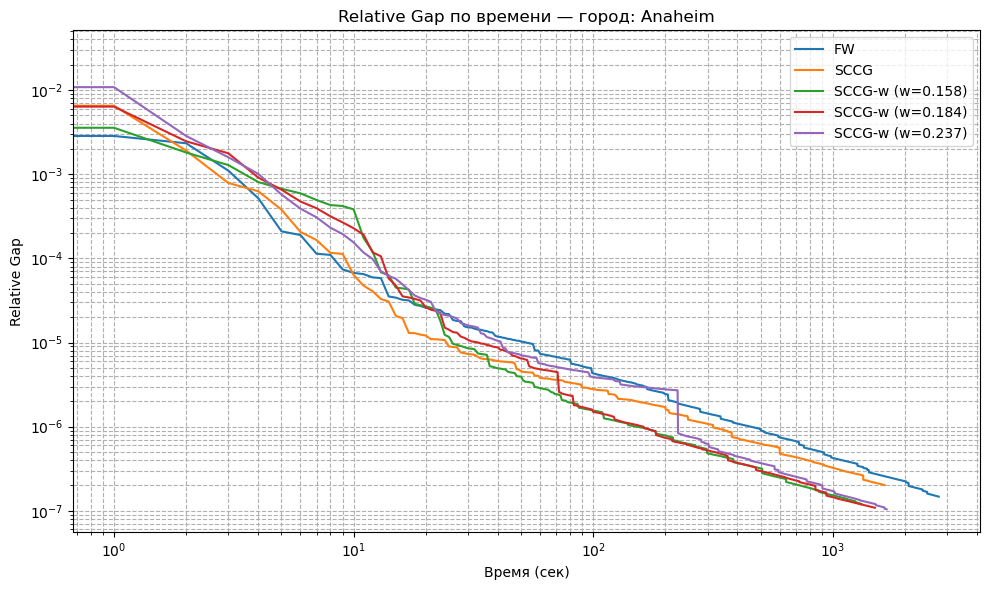

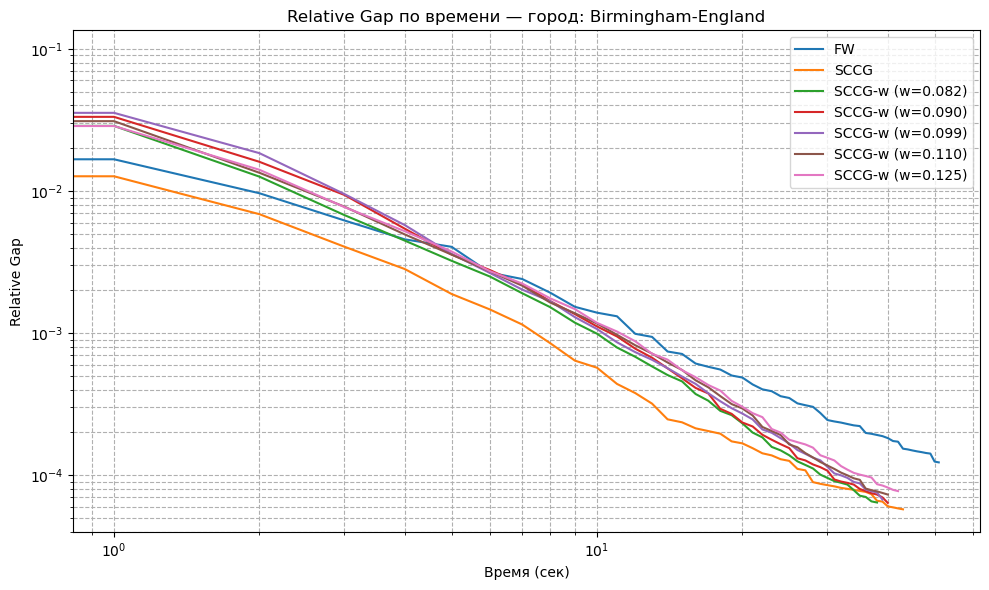

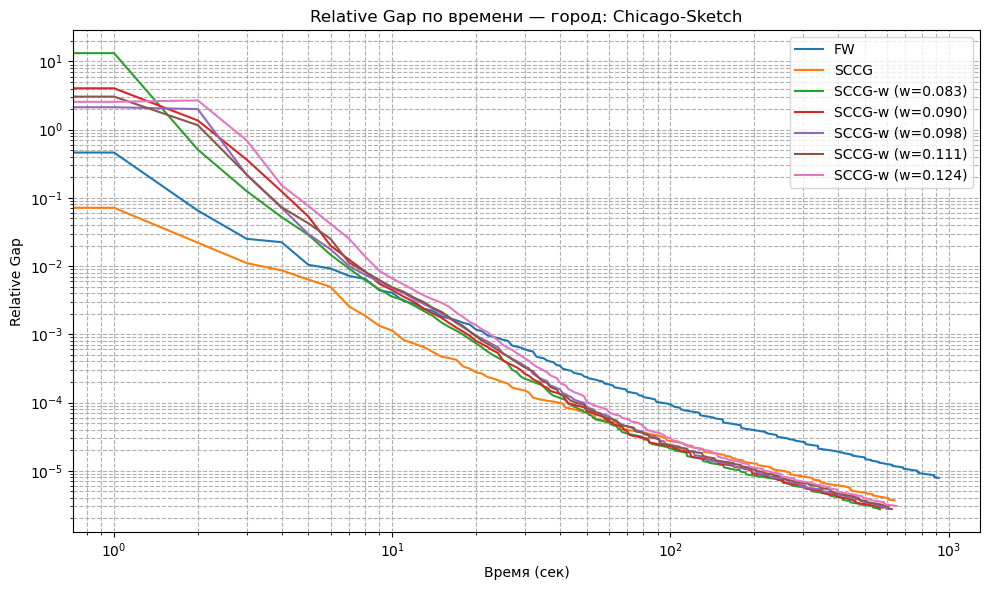

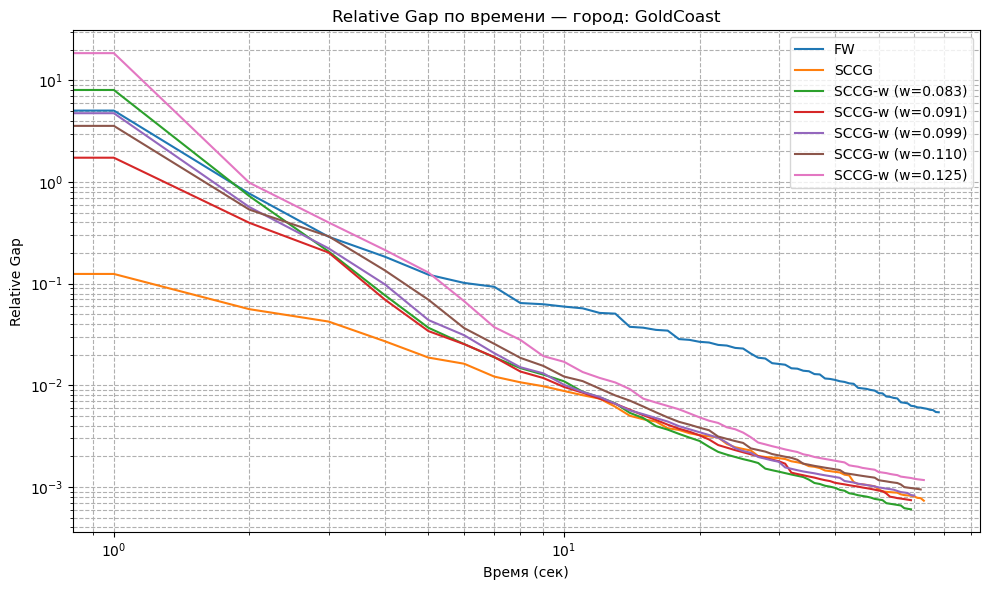

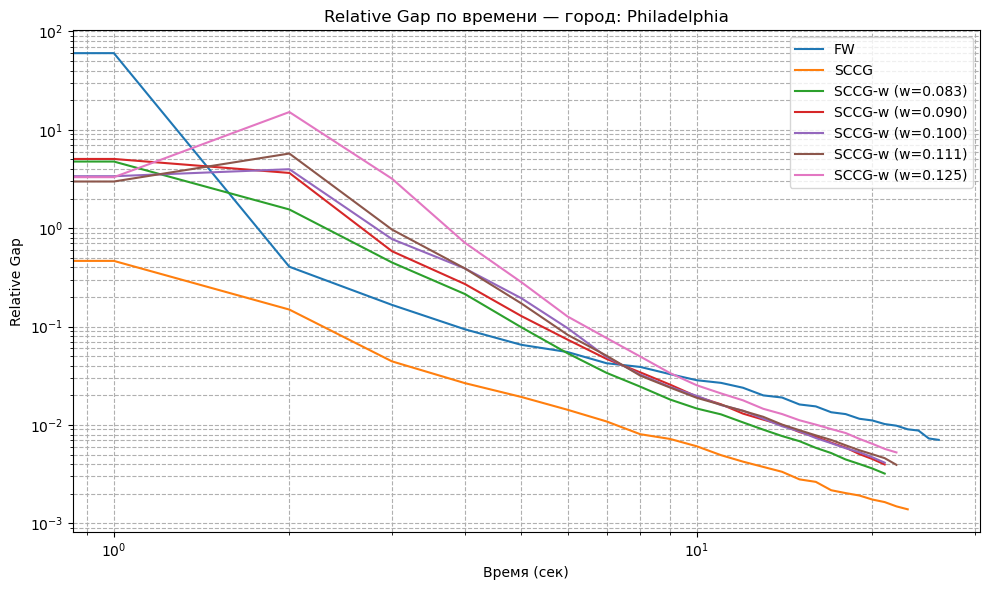

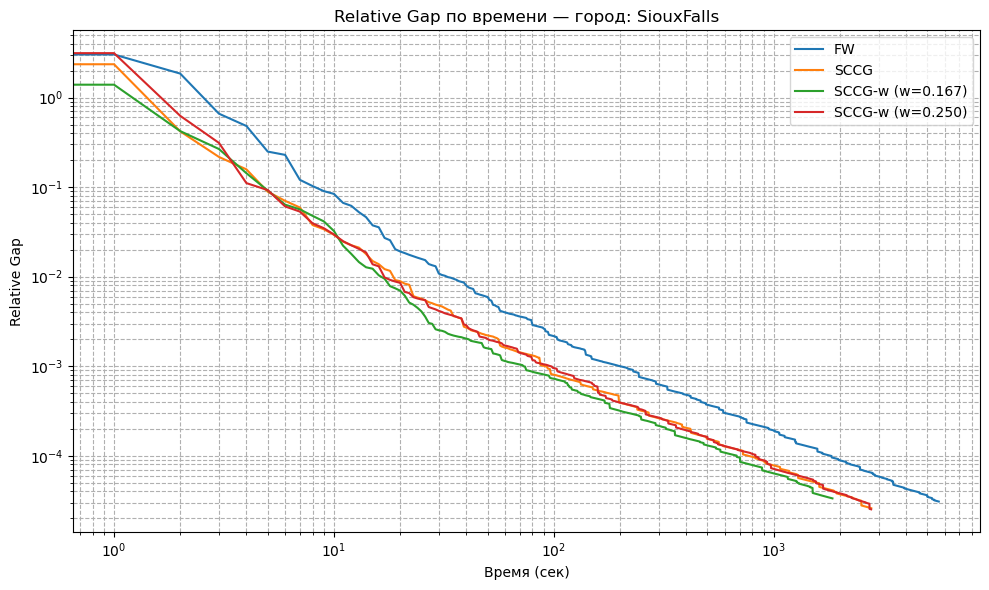

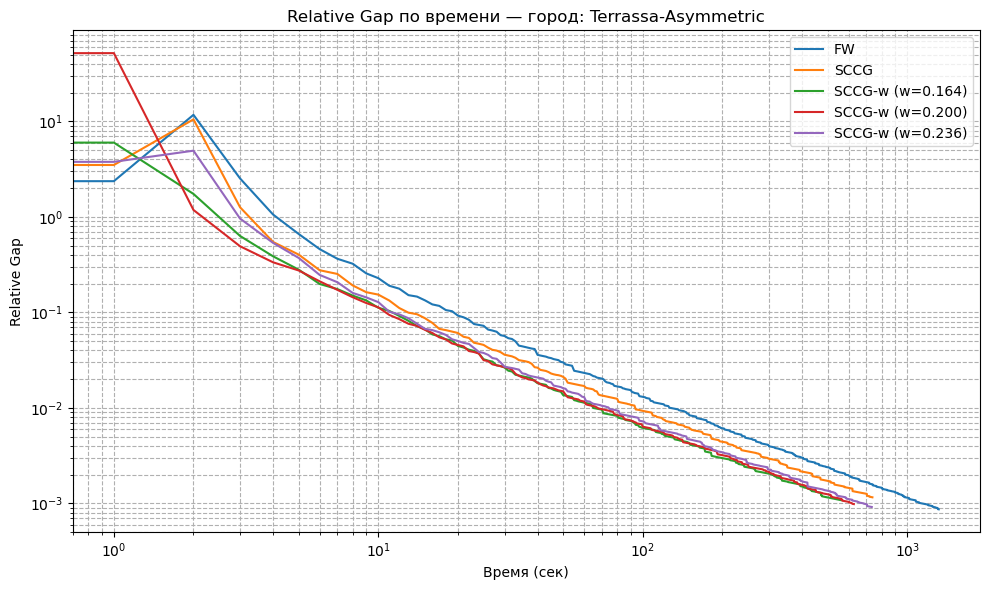

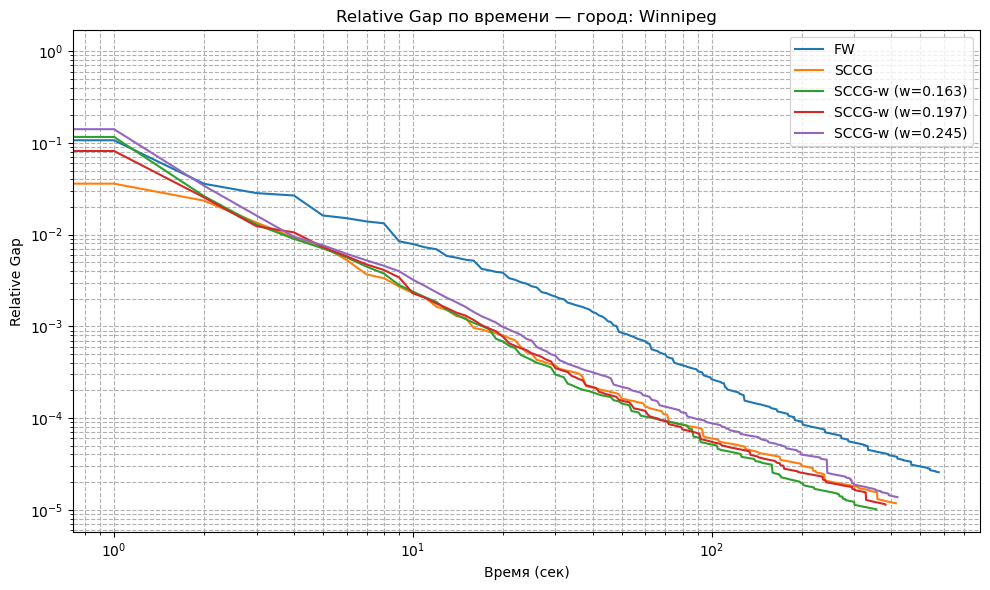

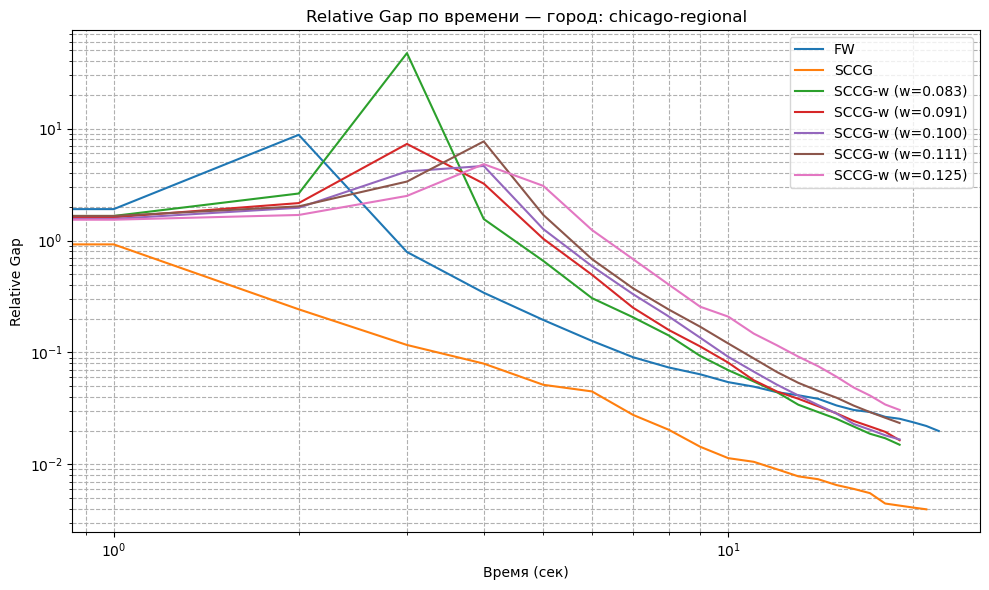

In [124]:
plot_results_by_city(results)